# IMPORTS

In [1]:
import sys
import os
from math import sqrt
import pandas_profiling
import rasterio
from rasterio import features
from rasterio.features import shapes
import gdal
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objs as go
from osgeo import gdal_array
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline
from math import floor

# CODIGO

In [1]:
list_years = list(range(2002,2018))

In [8]:
df_mfe.head()

,POLIGON,PROV_MFE50,CCAA_MFE50,TFCCTOT,TFCCARB,FCC_POND,TIPESTR,DISTRIB,FOR_MAN,SP1,...,TSP2,TSP3,TIPO_BOSQU,ID_FORARB,CLA_FORARB,NOM_FORARB,REGBIO,Shape_Leng,Shape_Area,geometry
0,194161,43,51,0.0,0.0,0.0,15.0,0.0,1.0,0.0,...,None,None,None,0.0,None,Sin formaciÃ³n arbolada,MED,269.598079,3451.751834,"POLYGON ((842476.2487000003 4599699.684599999,..."
1,194162,43,51,80.0,65.0,65.0,12.0,1.0,1.0,24.0,...,None,None,C,24.0,DOAUC240,Pinares de pino carrasco,MED,1429.898272,30955.369309,"POLYGON ((848847.1404999997 4603014.594799999,..."
2,194171,43,51,90.0,75.0,75.0,1.0,1.0,1.0,24.0,...,None,None,C,24.0,DOAUC240,Pinares de pino carrasco,MED,8071.554361,238942.436028,"POLYGON ((848077.2850000001 4603876.720000001,..."
3,194174,43,51,90.0,80.0,80.0,12.0,1.0,1.0,24.0,...,None,None,C,24.0,DOAUC240,Pinares de pino carrasco,MED,600.467280,21526.148997,"POLYGON ((848806.1914999997 4603489.497199999,..."
4,194177,43,51,70.0,50.0,50.0,12.0,1.0,1.0,24.0,...,None,None,C,24.0,DOAUC240,Pinares de pino carrasco,MED,1166.262909,20913.711249,"POLYGON ((848568.6292000003 4602463.115, 84855..."


In [64]:
catalunia = pd.DataFrame()

catalunia['PLACE'] = 'CATALUÑA'

In [111]:
andalucia = pd.DataFrame()

andalucia['PLACE'] = 'ANDALUCIA'

In [65]:
# Abrimos la capa que contiene el MFE 1:50.000 de cataluña que utilizaremos para hacer un intersect con los incendios

df_mfe =  gpd.read_file(r'C:\Users\Miguel\Desktop\Teledeteccion\MFE_50\MFE50CAT.shp')

df_mfe.drop(['Shape_Leng','Shape_Area','FOR_MAN', 'SP1', 'O1', 'E1', 'SP2', 'O2', 'E2',
       'SP3', 'O3', 'E3', 'REGBIO'], axis=1, inplace=True)

mask = None


for year in list_years:
    
    # Abrimos la capa con las teselas de los incendios de Cataluña y cambiamos la proyección a UTM huso 30

    path_incendisMFE = r'C:\Users\Miguel\Desktop\Teledeteccion\IncendisMFE/'

    file_incendisMFE = 'incmfe_' + str(year) +'.shp'
    
    fp_incendisMFE = path_incendisMFE + file_incendisMFE

    df_incendisMFE = gpd.read_file(fp_incendisMFE)
    
    df_incendisMFE = df_incendisMFE.to_crs({'init': 'epsg:25830'})
    
   # Cambiamos el nombre de la columna de area (año 2002 distinto al resto)
    
    if 'Area_Ha' in df_incendisMFE.columns:
        
        df_incendisMFE = df_incendisMFE.rename(columns={'Area_Ha' : 'Area_ha'})
        
    # Filtramos los incendios con superficie inferior o igual a 10 ha
    
    df_incendisMFE['Area_ha'] = df_incendisMFE.geometry.area / 10000
    
    df_incendisMFE = df_incendisMFE[df_incendisMFE['Area_ha'] > 10]
    
    # Creamos un indice que comienza en 1 y creamos un id unico de cada incendio con el año, CCAA y el indice
    
    df_incendisMFE['id_index'] = list(range(1,len(df_incendisMFE.index) + 1 ))
    
    df_incendisMFE['id'] = '{y}C'.format(y=year) + df_incendisMFE['id_index'].astype(str)
        
    # Llevamos a cabo un intersect entre la capa de incendios y el MFE 1:50.000 para obtener información sobre cobertura

    inter_mfe = gpd.overlay(df_mfe, df_incendisMFE, how='intersection')

    # Calculamos el área y el perimetro de cada nueva tesela creada 
    
    inter_mfe['Area_ha'] = inter_mfe['geometry'].area / 10000
    
    # Creamos un id unico de incendio por cobertura mfe 
    
    inter_mfe['id_incmfe_index'] = list(range(1,len(inter_mfe.index) + 1 ))
    
    inter_mfe['id_incmfe'] = inter_mfe['id'] + inter_mfe['id_incmfe_index'].astype(str)
    
    inter_mfe['Year'] = year
    
    # Abrimos la capa del algoritmo de la NASA y la vectorizamos
    
    path_NASA = r"C:\Users\Miguel\Desktop\Teledeteccion\BurnDate/BurnedArea"+ str(year) + ".tif"

    src = rasterio.open(path_NASA)

    image = src.read(1)


    results = (
            {'properties': {'raster_val': v}, 'geometry': s}

        for i, (s, v) in enumerate(
                features.shapes(image, mask=mask, transform=src.transform)))

    geoms = list(results)

    df_NASA  = gpd.GeoDataFrame.from_features(geoms)

    df_NASA = df_NASA[df_NASA['raster_val'] > 0]

    df_NASA.crs = {'init' :'epsg:4326'}
    
    df_NASA = df_NASA.to_crs({'init' :'epsg:25830'})
    
    
    # Intersecamos con la capa de los incendios que hemos obtenido anteriormente 
    
    inter_NASA = gpd.overlay(inter_mfe, df_NASA, how='intersection')
    
    # Calculamos el área de las nuevas teselas y filtramos aquellas con área despreciable 
    
    inter_NASA['Area_NASA'] = inter_NASA.geometry.area / 10000
    
    inter_NASA = inter_NASA[inter_NASA['Area_NASA'] > 0.01]
    
    # Abrimos la capa del algoritmo de OCD y la vectorizamos
    
    path_OCD = r"C:\Users\Miguel\Desktop\Teledeteccion\SUAV2SUM/SUAV2SUM_"+ str(year) + ".tif"

    src = rasterio.open(path_OCD)

    image = src.read(1)

    results = (
            {'properties': {'raster_val': v}, 'geometry': s}

        for i, (s, v) in enumerate(
                features.shapes(image, mask=mask, transform=src.transform)))

    geoms = list(results)

    df_OCD  = gpd.GeoDataFrame.from_features(geoms)

    df_OCD = df_OCD[df_OCD['raster_val'] > 0]

    df_OCD.crs = {'init' :'epsg:32630'}
    
    df_OCD = df_OCD.to_crs({'init' :'epsg:25830'})
    
    # Intersecamos con la capa de los incendios que hemos obtenido anteriormente 
    
    inter_OCD = gpd.overlay(inter_mfe, df_OCD, how='intersection')
    
    # Calculamos el área de las nuevas teselas y filtramos aquellas con área despreciable 
    
    inter_OCD['Area_OCD'] = inter_OCD.geometry.area / 10000
    
    inter_OCD = inter_OCD[inter_OCD['Area_OCD'] > 0.01]
    
    # Abrimos la capa del algoritmo de ACFCD y la vectorizamos
    
    path_ACFCD = r"C:\Users\Miguel\Desktop\Teledeteccion\Years/fullmapsum_"+ str(year) + ".tif"

    src = rasterio.open(path_ACFCD)

    image = src.read(1)

    results = (
            {'properties': {'raster_val': v}, 'geometry': s}

        for i, (s, v) in enumerate(
                features.shapes(image, mask=mask, transform=src.transform)))

    geoms = list(results)

    df_ACFCD  = gpd.GeoDataFrame.from_features(geoms)

    df_ACFCD = df_ACFCD[df_ACFCD['raster_val'] > 0]

    df_ACFCD.crs = {'init' :'epsg:32630'}
    
    df_ACFCD = df_ACFCD.to_crs({'init' :'epsg:25830'})
    
    # Intersecamos con la capa de los incendios que hemos obtenido anteriormente 
    
    inter_ACFCD = gpd.overlay(inter_mfe, df_ACFCD, how='intersection')
    
    # Calculamos el área de las nuevas teselas y filtramos aquellas con área despreciable 
    
    inter_ACFCD['Area_ACFCD'] = inter_ACFCD.geometry.area / 10000
    
    inter_ACFCD = inter_ACFCD[inter_ACFCD['Area_ACFCD'] > 0.01]
    
    # Calculamos el porcentaje de acierto por algoritmo y tesela
    
    for idx in inter_mfe.id_incmfe.unique():
    
        if idx in inter_ACFCD.id_incmfe.unique():

            AreaACFCD = inter_ACFCD[inter_ACFCD['id_incmfe'] == idx]['Area_ACFCD'].sum()

        else:

            AreaACFCD = 0.0

        if idx in inter_OCD.id_incmfe.unique():

            AreaOCD = inter_OCD[inter_OCD['id_incmfe'] == idx]['Area_OCD'].sum()

        else:

            AreaOCD = 0.0

        if idx in inter_NASA.id_incmfe.unique():

            AreaNASA = inter_NASA[inter_NASA['id_incmfe'] == idx]['Area_NASA'].sum()

        else:

            AreaNASA = 0.0

        AreaReal = inter_mfe[inter_mfe['id_incmfe'] == idx]['Area_ha'].sum()

        Supac_NASA = round((AreaNASA/AreaReal)*100, ndigits=2)

        Supac_OCD = round((AreaOCD/AreaReal)*100, ndigits=2)

        Supac_ACFCD = round((AreaACFCD/AreaReal)*100, ndigits=2)

        row =  {'id_incmfe' : [idx],
                'Area_NASA' : [AreaNASA],
                'Area_ACFCD' : [AreaACFCD],
                'Area_OCD' : [AreaOCD],
               'Supac_NASA' : [Supac_NASA],
               'Supac_ACFCD' : [Supac_ACFCD],
               'Supac_OCD' : [Supac_OCD]}

        df_row = pd.DataFrame.from_dict(row) 

        df_merge = pd.merge(inter_mfe, df_row, on='id_incmfe')

        catalunia = catalunia.append(df_merge, ignore_index=True)

In [68]:
catalunia.drop(['P','p','GRID_CODE','Dis','TSP1','TSP2','TSP3'], axis=1, inplace=True)

catalunia.to_csv('catalunia.csv',index=False)

In [72]:
catalunia_byid = catalunia.groupby(by='id').sum()

In [188]:
catalunia_byid.drop(['CCAA_MFE50_1', 'CCAA_MFE50_2', 'CLASMFE_IF', 'CLAS_IFN', 'DISTRIB', 'FCC_POND',
                     'ID_FORARB', 'OBJECTID', 'POLIGON', 'PROV_MFE50','TFCCARB', 'TFCCTOT', 'TIPESTR',
                     'Year','id_incmfe_index', 'id_index'],
                   axis=1,
                   inplace=True)

KeyError: "['CCAA_MFE50_1' 'CCAA_MFE50_2' 'CLASMFE_IF' 'CLAS_IFN' 'DISTRIB'\n 'FCC_POND' 'ID_FORARB' 'OBJECTID' 'POLIGON' 'PROV_MFE50' 'TFCCARB'\n 'TFCCTOT' 'TIPESTR' 'Year' 'id_incmfe_index' 'id_index'] not found in axis"

In [189]:
catalunia_byid['Supac_NASA'] = round((catalunia_byid['Area_NASA']/catalunia_byid['Area_ha'])*100, ndigits=2)

catalunia_byid['Supac_OCD'] = round((catalunia_byid['Area_OCD']/catalunia_byid['Area_ha'])*100, ndigits=2)

catalunia_byid['Supac_ACFCD'] = round((catalunia_byid['Area_ACFCD']/catalunia_byid['Area_ha'])*100, ndigits=2)

In [190]:
catalunia_byid['TODOS'] = 0

catalunia_byid.loc[(catalunia_byid.Area_NASA > 0) &
                   (catalunia_byid.Area_OCD > 0) &
                   (catalunia_byid.Area_ACFCD > 0),
                   'TODOS'] = 1

In [191]:
catalunia_byid['SOLO_NASA'] = 0

catalunia_byid.loc[(catalunia_byid.Area_NASA > 0) &
                   (catalunia_byid.Area_OCD == 0) &
                   (catalunia_byid.Area_ACFCD == 0),
                   'SOLO_NASA'] = 1

In [192]:
catalunia_byid['SOLO_ACFCD'] = 0

catalunia_byid.loc[(catalunia_byid.Area_NASA == 0) &
                   (catalunia_byid.Area_OCD > 0) &
                   (catalunia_byid.Area_ACFCD > 0),
                   'SOLO_ACFCD'] = 1

In [193]:
catalunia_byid['NASA_OCD'] = 0

catalunia_byid.loc[(catalunia_byid.Area_NASA > 0) &
                   (catalunia_byid.Area_OCD > 0) &
                   (catalunia_byid.Area_ACFCD == 0),
                   'NASA_OCD'] = 1

In [194]:
catalunia_byid.to_csv('catalunia_byid.csv')

In [152]:
list_years_and = [2002,
                 2003,
                 2004,
                 2005,
                 2006,
                 2007,
                 2008,
                 2009,
                 2010,
                 2011,
                 2012,
                 2013,
                 2015,
                 2016,
                 2017]

In [153]:
# Abrimos la capa que contiene el MFE 1:50.000 de andalucia que utilizaremos para hacer un intersect con los incendios

df_mfe =  gpd.read_file(r'C:\Users\Miguel\Desktop\Teledeteccion\MFE_And\MFE_AND.shp')

df_mfe.drop(['Shape_Leng','Shape_Area','FOR_MAN', 'SP1', 'O1', 'E1', 'SP2', 'O2', 'E2',
       'SP3', 'O3', 'E3', 'REGBIO'], axis=1, inplace=True)

mask = None


for year in list_years_and:
    
    # Abrimos la capa con las teselas de los incendios de Cataluña y cambiamos la proyección a UTM huso 30

    path_AreasRecorridasMFE = r'C:\Users\Miguel\Desktop\Teledeteccion/'

    file_AreasRecorridasMFE = 'incendiosmfe_' + str(year) +'.shp'
    
    fp_AreasRecorridasMFE = path_AreasRecorridasMFE + file_AreasRecorridasMFE

    df_AreasRecorridasMFE = gpd.read_file(fp_AreasRecorridasMFE)
    
    df_AreasRecorridasMFE = df_AreasRecorridasMFE.to_crs({'init': 'epsg:25830'})
    
   # Cambiamos el nombre de la columna de area (año 2002 distinto al resto)
    
    if 'Area_Ha' in df_AreasRecorridasMFE.columns:
        
        df_AreasRecorridasMFE = df_AreasRecorridasMFE.rename(columns={'Area_Ha' : 'Area_ha'})
        
    # Filtramos los incendios con superficie inferior o igual a 10 ha
    
    df_AreasRecorridasMFE['Area_ha'] = df_AreasRecorridasMFE.geometry.area / 10000
    
    df_AreasRecorridasMFE = df_AreasRecorridasMFE[df_AreasRecorridasMFE['Area_ha'] > 10]
    
    # Creamos un indice que comienza en 1 y creamos un id unico de cada incendio con el año, CCAA y el indice
    
    df_AreasRecorridasMFE['id_index'] = list(range(1,len(df_AreasRecorridasMFE.index) + 1 ))
    
    df_AreasRecorridasMFE['id'] = '{y}A'.format(y=year) + df_AreasRecorridasMFE['id_index'].astype(str)
        
    # Llevamos a cabo un intersect entre la capa de incendios y el MFE 1:50.000 para obtener información sobre cobertura

    inter_mfe = gpd.overlay(df_mfe, df_AreasRecorridasMFE, how='intersection')

    # Calculamos el área y el perimetro de cada nueva tesela creada 
    
    inter_mfe['Area_ha'] = inter_mfe['geometry'].area / 10000
    
    # Creamos un id unico de incendio por cobertura mfe 
    
    inter_mfe['id_incmfe_index'] = list(range(1,len(inter_mfe.index) + 1 ))
    
    inter_mfe['id_incmfe'] = inter_mfe['id'] + inter_mfe['id_incmfe_index'].astype(str)
    
    inter_mfe['Year'] = year
    
    # Abrimos la capa del algoritmo de la NASA y la vectorizamos
    
    path_NASA = r"C:\Users\Miguel\Desktop\Teledeteccion\BurnDate/BurnedArea"+ str(year) + ".tif"

    src = rasterio.open(path_NASA)

    image = src.read(1)


    results = (
            {'properties': {'raster_val': v}, 'geometry': s}

        for i, (s, v) in enumerate(
                features.shapes(image, mask=mask, transform=src.transform)))

    geoms = list(results)

    df_NASA  = gpd.GeoDataFrame.from_features(geoms)

    df_NASA = df_NASA[df_NASA['raster_val'] > 0]

    df_NASA.crs = {'init' :'epsg:4326'}
    
    df_NASA = df_NASA.to_crs({'init' :'epsg:25830'})
    
    
    # Intersecamos con la capa de los incendios que hemos obtenido anteriormente 
    
    inter_NASA = gpd.overlay(inter_mfe, df_NASA, how='intersection')
    
    # Calculamos el área de las nuevas teselas y filtramos aquellas con área despreciable 
    
    inter_NASA['Area_NASA'] = inter_NASA.geometry.area / 10000
    
    inter_NASA = inter_NASA[inter_NASA['Area_NASA'] > 0.01]
    
    # Abrimos la capa del algoritmo de OCD y la vectorizamos
    
    path_OCD = r"C:\Users\Miguel\Desktop\Teledeteccion\SUAV34/SUAV34SUM_"+ str(year) + ".tif"

    src = rasterio.open(path_OCD)

    image = src.read(1)

    results = (
            {'properties': {'raster_val': v}, 'geometry': s}

        for i, (s, v) in enumerate(
                features.shapes(image, mask=mask, transform=src.transform)))

    geoms = list(results)

    df_OCD  = gpd.GeoDataFrame.from_features(geoms)

    df_OCD = df_OCD[df_OCD['raster_val'] > 0]

    df_OCD.crs = {'init' :'epsg:32630'}
    
    df_OCD = df_OCD.to_crs({'init' :'epsg:25830'})
    
    # Intersecamos con la capa de los incendios que hemos obtenido anteriormente 
    
    inter_OCD = gpd.overlay(inter_mfe, df_OCD, how='intersection')
    
    # Calculamos el área de las nuevas teselas y filtramos aquellas con área despreciable 
    
    inter_OCD['Area_OCD'] = inter_OCD.geometry.area / 10000
    
    inter_OCD = inter_OCD[inter_OCD['Area_OCD'] > 0.01]
    
    # Abrimos la capa del algoritmo de ACFCD y la vectorizamos
    
    path_ACFCD = r"C:\Users\Miguel\Desktop\Teledeteccion\Years/fullmapsum_"+ str(year) + ".tif"

    src = rasterio.open(path_ACFCD)

    image = src.read(1)

    results = (
            {'properties': {'raster_val': v}, 'geometry': s}

        for i, (s, v) in enumerate(
                features.shapes(image, mask=mask, transform=src.transform)))

    geoms = list(results)

    df_ACFCD  = gpd.GeoDataFrame.from_features(geoms)

    df_ACFCD = df_ACFCD[df_ACFCD['raster_val'] > 0]

    df_ACFCD.crs = {'init' :'epsg:32630'}
    
    df_ACFCD = df_ACFCD.to_crs({'init' :'epsg:25830'})
    
    # Intersecamos con la capa de los incendios que hemos obtenido anteriormente 
    
    inter_ACFCD = gpd.overlay(inter_mfe, df_ACFCD, how='intersection')
    
    # Calculamos el área de las nuevas teselas y filtramos aquellas con área despreciable 
    
    inter_ACFCD['Area_ACFCD'] = inter_ACFCD.geometry.area / 10000
    
    inter_ACFCD = inter_ACFCD[inter_ACFCD['Area_ACFCD'] > 0.01]
    
    # Calculamos el porcentaje de acierto por algoritmo y tesela
    
    for idx in inter_mfe.id_incmfe.unique():
    
        if idx in inter_ACFCD.id_incmfe.unique():

            AreaACFCD = inter_ACFCD[inter_ACFCD['id_incmfe'] == idx]['Area_ACFCD'].sum()

        else:

            AreaACFCD = 0.0

        if idx in inter_OCD.id_incmfe.unique():

            AreaOCD = inter_OCD[inter_OCD['id_incmfe'] == idx]['Area_OCD'].sum()

        else:

            AreaOCD = 0.0

        if idx in inter_NASA.id_incmfe.unique():

            AreaNASA = inter_NASA[inter_NASA['id_incmfe'] == idx]['Area_NASA'].sum()

        else:

            AreaNASA = 0.0

        AreaReal = inter_mfe[inter_mfe['id_incmfe'] == idx]['Area_ha'].sum()

        Supac_NASA = round((AreaNASA/AreaReal)*100, ndigits=2)

        Supac_OCD = round((AreaOCD/AreaReal)*100, ndigits=2)

        Supac_ACFCD = round((AreaACFCD/AreaReal)*100, ndigits=2)

        row =  {'id_incmfe' : [idx],
                'Area_NASA' : [AreaNASA],
                'Area_ACFCD' : [AreaACFCD],
                'Area_OCD' : [AreaOCD],
               'Supac_NASA' : [Supac_NASA],
               'Supac_ACFCD' : [Supac_ACFCD],
               'Supac_OCD' : [Supac_OCD]}

        df_row = pd.DataFrame.from_dict(row) 

        df_merge = pd.merge(inter_mfe, df_row, on='id_incmfe')

        andalucia = andalucia.append(df_merge, ignore_index=True)

C:\Users\Miguel\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [154]:
andalucia.head()

,ARBOLADO,Area_ACFCD,Area_NASA,Area_OCD,Area_ha,CAMPANA,CCAA_MFE50,CLASMFE_IF,CLAS_IFN,CLA_FORARB,...,USOS_GENER,USOS_SUELO,Year,dis_str,geometry,id,id_incmfe,id_incmfe_index,id_index,p
0,0.0,0.0,0.0,0.0,8.046120e+00,2002,61.0,112.0,112.0,DOAUC230,...,Arbolado,Monte arbolado de plantaciÃ³n,2002.0,a,"POLYGON ((221211.779318389 4181396.667077032, ...",2002C41,2002C411,1.0,41.0,NaN
1,0.0,0.0,0.0,0.0,8.415746e+00,2002,61.0,113.0,113.0,STDEF920,...,Arbolado,Monte arbolado adehesado,2002.0,a,MULTIPOLYGON (((221346.2930750845 4182236.5813...,2002C41,2002C412,2.0,41.0,NaN
2,0.0,0.0,0.0,0.0,6.156391e+01,2002,61.0,110.0,111.0,DOAUF450,...,Arbolado,Monte arbolado,2002.0,a,MULTIPOLYGON (((221204.4319185069 4181396.6671...,2002C41,2002C413,3.0,41.0,NaN
3,0.0,0.0,0.0,0.0,4.695588e+00,2002,61.0,120.0,121.0,DOAUF450,...,Arbolado ralo,Monte con arbolado ralo,2002.0,a,MULTIPOLYGON (((221224.3255368056 4182043.7302...,2002C41,2002C414,4.0,41.0,NaN
4,0.0,0.0,0.0,0.0,5.889879e-11,2002,61.0,300.0,300.0,NaN,...,Artificial,Artificial,2002.0,a,MULTIPOLYGON (((221222.9321810316 4182043.0692...,2002C41,2002C415,5.0,41.0,NaN


In [155]:
andalucia.drop(['p','Dis','TSP1','TSP2','TSP3'], axis=1, inplace=True)

andalucia.to_csv('andalucia.csv',index=False)

In [156]:
andalucia_byid = andalucia.groupby(by='id').sum()

In [195]:
andalucia_byid.drop(['CLASMFE_IF', 'CLAS_IFN', 'DISTRIB', 'FCC_POND',
                     'ID_FORARB','POLIGON', 'PROV_MFE50','TFCCARB', 'TFCCTOT', 'TIPESTR',
                     'Year','id_incmfe_index', 'id_index'],
                   axis=1,
                   inplace=True)

In [196]:
andalucia_byid['Supac_NASA'] = round((andalucia_byid['Area_NASA']/andalucia_byid['Area_ha'])*100, ndigits=2)

andalucia_byid['Supac_OCD'] = round((andalucia_byid['Area_OCD']/andalucia_byid['Area_ha'])*100, ndigits=2)

andalucia_byid['Supac_ACFCD'] = round((andalucia_byid['Area_ACFCD']/andalucia_byid['Area_ha'])*100, ndigits=2)

In [197]:
andalucia_byid['TODOS'] = 0

andalucia_byid.loc[(andalucia_byid.Area_NASA > 0) &
                   (andalucia_byid.Area_OCD > 0) &
                   (andalucia_byid.Area_ACFCD > 0),
                   'TODOS'] = 1

In [198]:
andalucia_byid['SOLO_NASA'] = 0

andalucia_byid.loc[(andalucia_byid.Area_NASA > 0) &
                   (andalucia_byid.Area_OCD == 0) &
                   (andalucia_byid.Area_ACFCD == 0),
                   'SOLO_NASA'] = 1

In [199]:
andalucia_byid['SOLO_ACFCD'] = 0

andalucia_byid.loc[(andalucia_byid.Area_NASA == 0) &
                   (andalucia_byid.Area_OCD > 0) &
                   (andalucia_byid.Area_ACFCD > 0),
                   'SOLO_ACFCD'] = 1

In [200]:
andalucia_byid['NASA_OCD'] = 0

andalucia_byid.loc[(andalucia_byid.Area_NASA > 0) &
                   (andalucia_byid.Area_OCD > 0) &
                   (andalucia_byid.Area_ACFCD == 0),
                   'NASA_OCD'] = 1

In [201]:
andalucia_byid.to_csv('andalucia_byid.csv')

In [164]:
andalucia_byid.tail()

,ARBOLADO,Area_ACFCD,Area_NASA,Area_OCD,Area_ha,CCAA_MFE50,FECHA_INIC,ID,Id,MATORRAL,...,RESOLUCION,SHAPE_AREA,SUPERFICIE,Supac_ACFCD,Supac_NASA,Supac_OCD,TODOS,SOLO_NASA,SOLO_ACFCD,NASA_OCD
id,,,,,,,,,,,,,,,,,,,,,
2017C58,0.0,2974.331526,8579.782084,5297.132203,9846.395928,24644.0,8.148932e+09,0.0,0.0,0.0,...,808.0,4179137.60,0.0,30.21,87.14,53.8,1,0,0,0
2017C6,0.0,0.000000,0.000000,0.000000,15.246563,122.0,4.034162e+07,0.0,0.0,0.0,...,20.0,33.86,0.0,0.00,0.00,0.0,0,0,0,0
2017C7,0.0,0.000000,0.000000,4.796475,16.542181,183.0,6.051215e+07,0.0,0.0,0.0,...,30.0,49.62,0.0,0.00,0.00,29.0,0,0,0,0
2017C8,0.0,0.000000,0.000000,0.000000,16.225993,183.0,6.051185e+07,0.0,0.0,0.0,...,30.0,60.45,0.0,0.00,0.00,0.0,0,0,0,0
2017C9,0.0,0.000000,0.000000,0.000000,17.540259,122.0,4.034126e+07,0.0,0.0,0.0,...,20.0,37.70,0.0,0.00,0.00,0.0,0,0,0,0


In [165]:
catalunia_byid.columns

Index(['id', 'Area_ACFCD', 'Area_NASA', 'Area_OCD', 'Area_ha', 'Supac_ACFCD',
       'Supac_NASA', 'Supac_OCD', 'TODOS', 'SOLO_NASA', 'SOLO_ACFCD',
       'NASA_OCD', 'NINGUNO', 'SOLO_OCD', 'TOT_ACFCD', 'TOT_NASA', 'TOT_OCD',
       'AREA_RANGE', 'Tamaño', 'TOT_ACFCD1', 'TOT_NASA1', 'TOT_OCD1'],
      dtype='object')

In [166]:
andalucia_byid.columns

Index(['ARBOLADO', 'Area_ACFCD', 'Area_NASA', 'Area_OCD', 'Area_ha',
       'CCAA_MFE50', 'FECHA_INIC', 'ID', 'Id', 'MATORRAL', 'PASTIZALES',
       'PLACE', 'RESOLUCION', 'SHAPE_AREA', 'SUPERFICIE', 'Supac_ACFCD',
       'Supac_NASA', 'Supac_OCD', 'TODOS', 'SOLO_NASA', 'SOLO_ACFCD',
       'NASA_OCD'],
      dtype='object')

In [167]:
andalucia = pd.read_csv('andalucia.csv')
catalunia = pd.read_csv('catalunia.csv')

complete = pd.concat([andalucia,catalunia], ignore_index=True, sort=False)

complete.DEFINICION.unique()

array(['Bosque PlantaciÃ³n', 'Dehesa', 'Bosque', 'Artificial',
       'AgrÃ\xadcola y prados artificiales', 'Herbazal', 'Matorral',
       'Pastizal-Matorral', 'MinerÃ\xada, escombreras y vertederos',
       'T. D. (Incendio)', 'Infraestructuras de conducciÃ³n',
       'A.F.M. (Riberas)', 'Mosaico desarbolado sobre cultivo', 'Humedal',
       'Complementos del bosque', 'Agua', 'Autopistas y autovÃ\xadas',
       'A.F.M. (Bosquetes)', 'Mosaico arbolado sobre cultivo', 'Prado',
       'Cultivo con arbolado disperso', 'T. D. (Talas)',
       'Mosaico arbolado sobre forestal desarbolado',
       'Monte sin vegetaciÃ³n superior', 'Ã\x81rea recreativa',
       'Prado con sebes', 'A.F.M. (Alineaciones)'], dtype=object)

In [168]:
andalucia.id.unique()

array(['2002C41', '2002C22', '2002C35', ..., '2017A11', '2017A23',
       '2017A53'], dtype=object)

In [169]:
complete.id.unique()

array(['2002C41', '2002C22', '2002C35', ..., '2014C3', '2014C1', '2014C2'],
      dtype=object)

In [170]:
def special(my_str):
    
    import re

    my_new_string = re.sub('[^a-zA-Z0-9 \n\.]', '', my_str)
    
    return my_new_string

In [171]:
complete['DEFINICION'] = complete['DEFINICION'].apply(special)

In [172]:
complete.DEFINICION.unique()

array(['Bosque Plantacin', 'Dehesa', 'Bosque', 'Artificial',
       'Agrcola y prados artificiales', 'Herbazal', 'Matorral',
       'PastizalMatorral', 'Minera escombreras y vertederos',
       'T. D. Incendio', 'Infraestructuras de conduccin',
       'A.F.M. Riberas', 'Mosaico desarbolado sobre cultivo', 'Humedal',
       'Complementos del bosque', 'Agua', 'Autopistas y autovas',
       'A.F.M. Bosquetes', 'Mosaico arbolado sobre cultivo', 'Prado',
       'Cultivo con arbolado disperso', 'T. D. Talas',
       'Mosaico arbolado sobre forestal desarbolado',
       'Monte sin vegetacin superior', 'rea recreativa',
       'Prado con sebes', 'A.F.M. Alineaciones'], dtype=object)

In [173]:
usos_ajenos = ['Artificial',
       'Agrcola y prados artificiales',
       'Minera escombreras y vertederos',
       'Infraestructuras de conduccin',
       'A.F.M. Riberas', 'Mosaico desarbolado sobre cultivo', 'Humedal',
       'Agua', 'Autopistas y autovas',
       'Mosaico arbolado sobre cultivo',
       'Cultivo con arbolado disperso',
       'rea recreativa']

In [174]:
for uso in usos_ajenos:

    complete = complete.drop(complete[complete.DEFINICION == uso].index,axis=0)

In [175]:
complete.DEFINICION.unique()

array(['Bosque Plantacin', 'Dehesa', 'Bosque', 'Herbazal', 'Matorral',
       'PastizalMatorral', 'T. D. Incendio', 'Complementos del bosque',
       'A.F.M. Bosquetes', 'Prado', 'T. D. Talas',
       'Mosaico arbolado sobre forestal desarbolado',
       'Monte sin vegetacin superior', 'Prado con sebes',
       'A.F.M. Alineaciones'], dtype=object)

In [176]:
complete.to_csv('complete.csv', index=False)

In [177]:
def get_place(string):
    
    place_letter = string[4:5]
    
    if place_letter == 'C':
        
        place = 'CATALUNA'
        
    elif place_letter == 'A':
        
        place = 'ANDALUCIA'
    
    return place

In [178]:
complete['PLACE'] = complete['id'].apply(get_place)

In [179]:
andalucia = complete[complete['PLACE'] == 'ANDALUCIA']

cataluna = complete[complete['PLACE'] == 'CATALUNA']

In [180]:
complete.PLACE.unique()

array(['CATALUNA', 'ANDALUCIA'], dtype=object)

In [184]:
andalucia_byid = andalucia.groupby(by='id').sum()

cataluna_byid = cataluna.groupby(by='id').sum()

In [209]:
all_df = [andalucia_byid,catalunia_byid]

df_str = ['Andalucia','Cataluña']

In [219]:
all_df[0]

,ARBOLADO,Area_ACFCD,Area_NASA,Area_OCD,Area_ha,CAMPANA,CCAA_MFE50,FECHA,FECHA_INIC,ID,...,NASA_OCD,TOT_ACFCD,TOT_NASA,TOT_OCD,AREA_RANGE,Tamaño,TOT_ACFCD1,TOT_NASA1,TOT_OCD1,id
id,,,,,,,,,,,,,,,,,,,,,
2002A1,0.0,0.000000,0.000000,0.000000,10.100998,4004.0,122.0,4004.0,4.004145e+07,94.0,...,0,0,0,0,0,Normal,NaN,NaN,NaN,2002A1
2002A10,0.0,0.000000,0.000000,0.000000,31.809505,18018.0,549.0,18018.0,1.801873e+08,558.0,...,0,0,0,0,0,Normal,NaN,NaN,NaN,2002A10
2002A11,0.0,0.000000,0.000000,0.000000,23.353090,12012.0,366.0,12012.0,1.201297e+08,312.0,...,0,0,0,0,0,Normal,NaN,NaN,NaN,2002A11
2002A12,0.0,0.000000,0.000000,0.000000,28.535657,6006.0,183.0,6006.0,6.006243e+07,45.0,...,0,0,0,0,0,Normal,NaN,NaN,NaN,2002A12
2002A13,0.0,0.000000,0.000000,0.000000,25.399720,2002.0,61.0,2002.0,2.002072e+07,45.0,...,0,0,0,0,0,Normal,NaN,NaN,NaN,2002A13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017A58,0.0,2942.762403,8435.167648,5190.973411,9692.365719,685780.0,20740.0,685780.0,6.858012e+09,0.0,...,0,1,1,1,6,GIF,1.0,1.0,1.0,2017A58
2017A6,0.0,0.000000,0.000000,0.000000,15.246563,2017.0,61.0,2017.0,2.017081e+07,0.0,...,0,0,0,0,0,Normal,NaN,NaN,NaN,2017A6
2017A7,0.0,0.000000,0.000000,4.796475,16.542181,6051.0,183.0,6051.0,6.051215e+07,0.0,...,0,0,0,1,0,Normal,NaN,NaN,1.0,2017A7


In [217]:
for df in all_df:
    
    df['id'] = df.index

In [186]:
for df in all_df:
    
    df['SOLO_OCD'] = 0

    df.loc[(df.Area_NASA == 0) &
                   (df.Area_OCD > 0) &
                   (df.Area_ACFCD == 0),
                   'SOLO_OCD'] = 1

In [202]:
for df in all_df:
    
    df['TOT_ACFCD'] = df['SOLO_ACFCD'] + df['TODOS']
    
    df['TOT_NASA'] = df['SOLO_NASA'] + df['TODOS'] + df['NASA_OCD']
    
    df['TOT_OCD'] = df['SOLO_ACFCD'] + df['TODOS'] + df['SOLO_OCD'] + df['NASA_OCD']

In [203]:
for df in all_df:
    
    df['AREA_RANGE'] = 0
    
    df.loc[df['Area_ha'] <= 50, 'AREA_RANGE'] = 0 #50
    
    df.loc[(df['Area_ha'] > 50) & (df['Area_ha'] <= 100), 'AREA_RANGE'] = 1 #100
    
    df.loc[(df['Area_ha'] > 100) & (df['Area_ha'] <= 250), 'AREA_RANGE'] = 2 #250
    
    df.loc[(df['Area_ha'] > 250) & (df['Area_ha'] <= 500), 'AREA_RANGE'] = 3 #500
    
    df.loc[(df['Area_ha'] > 500) & (df['Area_ha'] <= 1000), 'AREA_RANGE'] = 4 #1000
    
    df.loc[(df['Area_ha'] > 1000) & (df['Area_ha'] <= 5000), 'AREA_RANGE'] = 5 #5000
    
    df.loc[df['Area_ha'] >= 5000, 'AREA_RANGE'] = 6 #10000

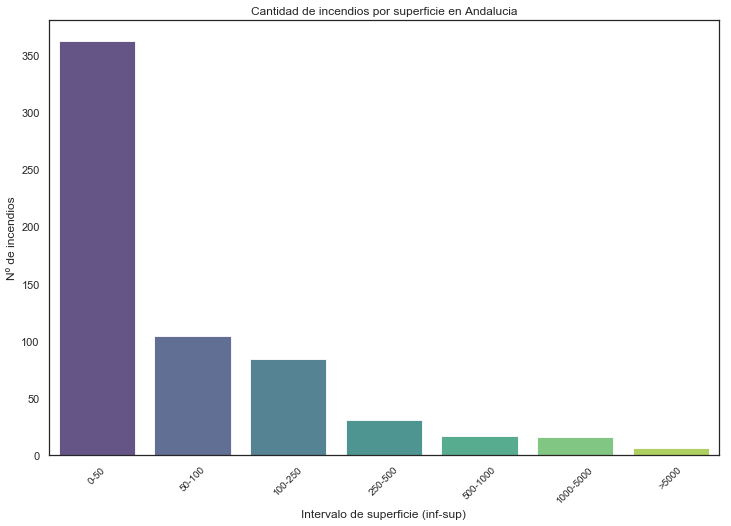

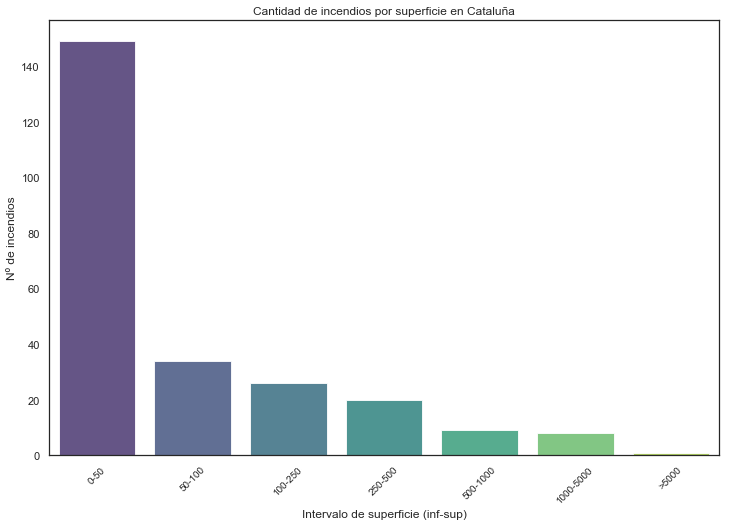

In [204]:
for j, df in enumerate(all_df):
    
    sns.set(style="white")
    
    plt.figure(figsize=(12,8))
    
    chart = sns.countplot(df['AREA_RANGE'],
                         palette='viridis',
                         alpha=0.85)
    
    chart.set(title='Cantidad de incendios por superficie en ' + str(df_str[j]),
              xlabel='Intervalo de superficie (inf-sup)',
              ylabel='Nº de incendios')
    
    chart.set_xticklabels(['0-50','50-100','100-250','250-500','500-1000','1000-5000','>5000'],
                          rotation=45,
                          fontsize=10)

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




[Text(0, 0, '0-50'),
 Text(0, 0, '50-100'),
 Text(0, 0, '100-250'),
 Text(0, 0, '250-500'),
 Text(0, 0, '500-1000'),
 Text(0, 0, '1000-5000'),
 Text(0, 0, '>5000')]

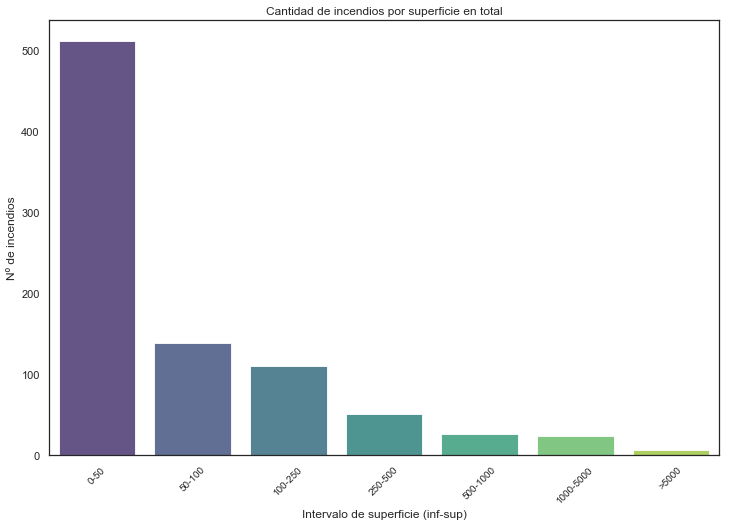

In [205]:
full_results = pd.concat(all_df)

df = full_results

sns.set(style="white")
    
plt.figure(figsize=(12,8))
    
chart = sns.countplot(df['AREA_RANGE'],
                         palette='viridis',
                         alpha=0.85)
    
chart.set(title='Cantidad de incendios por superficie en total',
              xlabel='Intervalo de superficie (inf-sup)',
              ylabel='Nº de incendios')
    
chart.set_xticklabels(['0-50','50-100','100-250','250-500','500-1000','1000-5000','>5000'],
                          rotation=45,
                          fontsize=10)

In [206]:
for df in all_df:
    
    df['Tamaño'] = 0
    
    df.loc[df['Area_ha'] > 500, 'Tamaño'] = 'GIF'
    
    df.loc[df['Area_ha'] < 500, 'Tamaño'] = 'Normal'

In [207]:
for df in all_df:
    
    df['TOT_ACFCD1'] = df[df['TOT_ACFCD'] == 1]['TOT_ACFCD']
    
    df['TOT_NASA1'] = df[df['TOT_NASA'] == 1]['TOT_NASA']
    
    df['TOT_OCD1'] = df[df['TOT_OCD'] == 1]['TOT_OCD']

In [213]:
for j, df in enumerate(all_df): 

    Total_registros = len(df.index)

    Actual_NASA = df[df['TOT_NASA'] == 1].count()['TOT_NASA']

    Actual_ACFCD = df[df['TOT_ACFCD'] == 1].count()['TOT_ACFCD']

    Actual_OCD = df[df['TOT_OCD'] == 1].count()['TOT_OCD']

    Aciertos_CDV6 = Actual_ACFCD/Total_registros * 100

    Aciertos_NASA = Actual_NASA/Total_registros * 100

    Aciertos_OCD = Actual_OCD/Total_registros * 100


    print(df_str[j] + " Total aciertos (n) ACFCD: {a}%, Total aciertos NASA: {b}%, Total aciertos OCD: {c}%".format\
      (a=floor(Aciertos_CDV6), b=floor(Aciertos_NASA), c=floor(Aciertos_OCD)))
    
    print('\n')

Andalucia Total aciertos (n) ACFCD: 20%, Total aciertos NASA: 15%, Total aciertos OCD: 28%


Cataluña Total aciertos (n) ACFCD: 44%, Total aciertos NASA: 19%, Total aciertos OCD: 54%




In [214]:
for j, df in enumerate(all_df):
    

    Total_Area = df['Area_ha'].sum()


    Superficie_acertada_ACFCD = df['Area_ACFCD'].sum()

    Superficie_acertada_NASA = df['Area_NASA'].sum()

    Superficie_acertada_OCD = df['Area_OCD'].sum()


    Aciertos_sup_ACFCD =  100 * (Superficie_acertada_ACFCD / Total_Area)

    Aciertos_sup_NASA =  100 * (Superficie_acertada_NASA / Total_Area)

    Aciertos_sup_OCD = 100 * (Superficie_acertada_OCD / Total_Area)


    print(df_str[j] + " Total aciertos (% Sup) ACFCD: {a}%, Total aciertos NASA: {b}%, Total aciertos OCD: {c}%".format\
      (a=floor(Aciertos_sup_ACFCD), b=floor(Aciertos_sup_NASA), c=floor(Aciertos_sup_OCD)))
    
    print('\n')

Andalucia Total aciertos (% Sup) ACFCD: 34%, Total aciertos NASA: 66%, Total aciertos OCD: 43%


Cataluña Total aciertos (% Sup) ACFCD: 57%, Total aciertos NASA: 57%, Total aciertos OCD: 65%




In [215]:
def Validacion_Area(inf,sup):
    
    inf = int(inf)
    sup = int(sup)
    
    df_val = df[(df['Area_ha'] >= inf) & (df['Area_ha'] <= sup)]
    
    Total_registros = df_val['id'].count()
    Actual_NASA = df_val[df_val['TOT_NASA'] == 1].count()['TOT_NASA']
    Actual_ACFCD = df_val[df_val['TOT_ACFCD'] == 1].count()['TOT_ACFCD']
    Actual_OCD = df_val[df_val['TOT_OCD'] == 1].count()['TOT_OCD']
    
    Aciertos_ACFCD = Actual_ACFCD/Total_registros *100
    Aciertos_NASA = Actual_NASA/Total_registros *100
    Aciertos_OCD = Actual_OCD/Total_registros *100


    print("Total aciertos (n) ACFCD: {a}%, Total aciertos NASA: {b}%, Total aciertos OCD: {c}%".format\
      (a=floor(Aciertos_ACFCD), b=floor(Aciertos_NASA), c=floor(Aciertos_OCD)))
    

    Total_Area = df_val['Area_ha'].sum()

    Superficie_acertada_ACFCD = df_val['Area_ACFCD'].sum()
    Superficie_acertada_NASA = df_val['Area_NASA'].sum()
    Superficie_acertada_OCD = df_val['Area_OCD'].sum()

    Aciertos_sup_ACFCD =  100 * (Superficie_acertada_ACFCD / Total_Area)
    Aciertos_sup_NASA =  100 * (Superficie_acertada_NASA / Total_Area)
    Aciertos_sup_OCD = 100 * (Superficie_acertada_OCD / Total_Area)

    print("Total aciertos (% Sup) ACFCD: {a}%, Total aciertos NASA: {b}%, Total aciertos OCD: {c}%".format\
          (a=floor(Aciertos_sup_ACFCD), b=floor(Aciertos_sup_NASA), c=floor(Aciertos_sup_OCD)))
    
    return Aciertos_ACFCD, Aciertos_NASA, Aciertos_OCD, Aciertos_sup_ACFCD, Aciertos_sup_NASA, Aciertos_sup_OCD

In [218]:
lista_limites = [[10,100],[100,250],[250,500],[500,20000]]

df_sup_naciertos = pd.DataFrame(columns=['PLACE','LIM_INF','LIM_SUP','Aciertos_ACFCD','Aciertos_NASA','Aciertos_OCD'])

df_sup_superficie = pd.DataFrame(columns=['PLACE','LIM_INF','LIM_SUP','Aciertos_sup_ACFCD','Aciertos_sup_NASA',
                                          'Aciertos_sup_OCD'])

for j, df in enumerate(all_df):
    
    for lim in lista_limites:
        
        a = lim[0]
        b = lim[1]
        
        print(df_str[j])
        
        print('Limites inferior-superior (ha): '  + str(a) + '-' + str(b)) 
    
        Aciertos_ACFCD, Aciertos_NASA, Aciertos_OCD, \
        Aciertos_sup_ACFCD, Aciertos_sup_NASA, Aciertos_sup_OCD = Validacion_Area(a,b)
    
        row_n = {'PLACE' : df_str[j], 'LIM_INF' : a, 'LIM_SUP' : b, 'Aciertos_ACFCD' : Aciertos_ACFCD,
           'Aciertos_NASA' : Aciertos_NASA, 'Aciertos_OCD' : Aciertos_OCD}
    
        row_sup = {'PLACE' : df_str[j], 'LIM_INF' : a, 'LIM_SUP' : b, 'Aciertos_sup_ACFCD' : Aciertos_sup_ACFCD,
           'Aciertos_sup_NASA' : Aciertos_sup_NASA, 'Aciertos_sup_OCD' : Aciertos_sup_OCD}
    
        df_sup_naciertos = df_sup_naciertos.append(row_n, ignore_index=True)
        
        df_sup_superficie = df_sup_superficie.append(row_sup, ignore_index=True)
    
        print('\n')

Andalucia
Limites inferior-superior (ha): 10-100
Total aciertos (n) ACFCD: 8%, Total aciertos NASA: 2%, Total aciertos OCD: 14%
Total aciertos (% Sup) ACFCD: 2%, Total aciertos NASA: 2%, Total aciertos OCD: 5%


Andalucia
Limites inferior-superior (ha): 100-250
Total aciertos (n) ACFCD: 42%, Total aciertos NASA: 30%, Total aciertos OCD: 59%
Total aciertos (% Sup) ACFCD: 12%, Total aciertos NASA: 14%, Total aciertos OCD: 18%


Andalucia
Limites inferior-superior (ha): 250-500
Total aciertos (n) ACFCD: 64%, Total aciertos NASA: 83%, Total aciertos OCD: 74%
Total aciertos (% Sup) ACFCD: 18%, Total aciertos NASA: 50%, Total aciertos OCD: 31%


Andalucia
Limites inferior-superior (ha): 500-20000
Total aciertos (n) ACFCD: 84%, Total aciertos NASA: 94%, Total aciertos OCD: 89%
Total aciertos (% Sup) ACFCD: 33%, Total aciertos NASA: 79%, Total aciertos OCD: 43%


Cataluña
Limites inferior-superior (ha): 10-100
Total aciertos (n) ACFCD: 30%, Total aciertos NASA: 3%, Total aciertos OCD: 43%
Tota

In [221]:
by_sup = df_sup_superficie.groupby(['LIM_INF','LIM_SUP','PLACE']).sum()
by_sup.head(10)

Aciertos_sup_ACFCD  Aciertos_sup_NASA  \
LIM_INF LIM_SUP PLACE                                              
10      100     Andalucia            2.889320           2.001004   
                Cataluña            16.737391           2.419767   
100     250     Andalucia           12.882615          14.847401   
                Cataluña            38.740706          19.042375   
250     500     Andalucia           18.191000          50.807892   
                Cataluña            44.870513          37.384399   
500     20000   Andalucia           33.305891          79.410659   
                Cataluña            71.598969          78.890444   

                           Aciertos_sup_OCD  
LIM_INF LIM_SUP PLACE                        
10      100     Andalucia          5.755988  
                Cataluña          23.991539  
100     250     Andalucia         18.563678  
                Cataluña          44.253238  
250     500     Andalucia         31.369295  
                Cataluña          53.778876  
500     20000   Andalucia         43.460349  
                Cataluña          79.556690

Text(0.5, 0, 'Intervalo de superficie (inf-sup)')

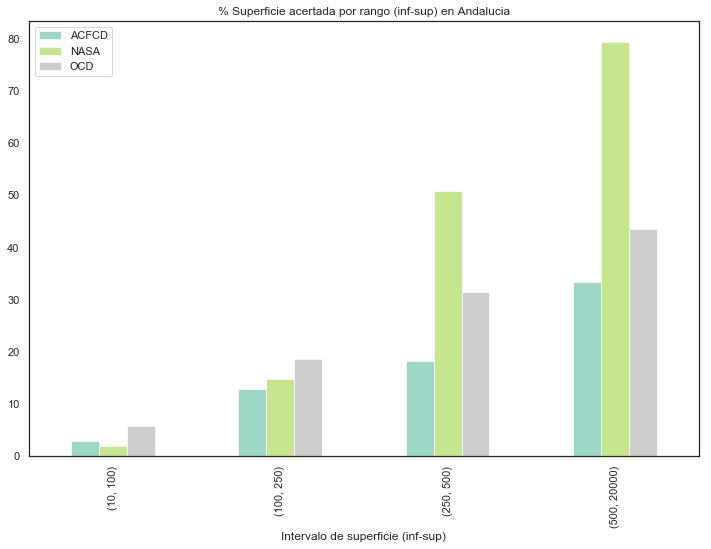

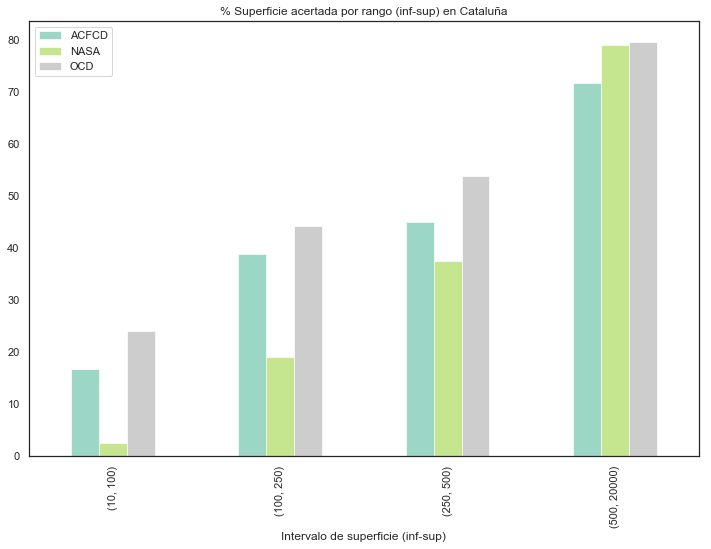

In [222]:
df_sup_superficie_and = df_sup_superficie[df_sup_superficie['PLACE'] == 'Andalucia']

df_sup_superficie_cat = df_sup_superficie[df_sup_superficie['PLACE'] == 'Cataluña']

by_sup_and = df_sup_superficie_and.groupby(['LIM_INF','LIM_SUP']).sum()

by_sup_cat = df_sup_superficie_cat.groupby(['LIM_INF','LIM_SUP']).sum()

chart_and = by_sup_and.plot(kind='bar', 
                figsize=(12,8),
                title='% Superficie acertada por rango (inf-sup) en Andalucia',
                colormap='Set2',
                alpha=0.65)

chart_and.legend(['ACFCD', 'NASA','OCD'])
chart_and.set_xlabel("Intervalo de superficie (inf-sup)")

chart_cat = by_sup_cat.plot(kind='bar', 
                figsize=(12,8),
                title='% Superficie acertada por rango (inf-sup) en Cataluña',
                colormap='Set2',
                alpha=0.65)

chart_cat.legend(['ACFCD', 'NASA','OCD'])
chart_cat.set_xlabel("Intervalo de superficie (inf-sup)")

In [226]:
def extract_year(string):
    
    year = int(string[:4])
    
    return year

TypeError: 'int' object is not subscriptable

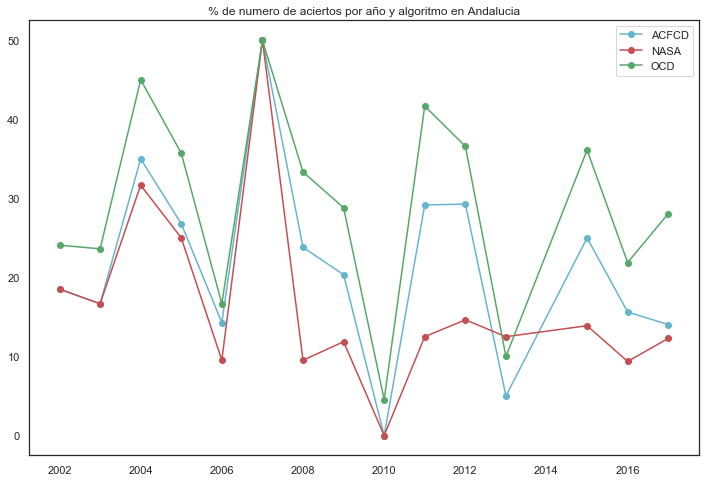

In [227]:
for j, df in enumerate(all_df):
    
    df['Reg'] = 1
    
    df['YEAR'] = df['id'].apply(extract_year)

    by_year = df.groupby(['YEAR']).sum()

    plt.figure(figsize=(12,8))

    plt.plot((by_year['TOT_ACFCD'] /  by_year['Reg']) * 100, color='c', marker='o')

    plt.plot((by_year['TOT_NASA'] /  by_year['Reg']) * 100, color='r', marker='o')

    plt.plot((by_year['TOT_OCD'] /  by_year['Reg']) * 100, color='g', marker='o')

    plt.legend(labels=['ACFCD','NASA','OCD'])

    plt.title(label='% de numero de aciertos por año y algoritmo en ' + df_str[j])

KeyError: 'YEAR'

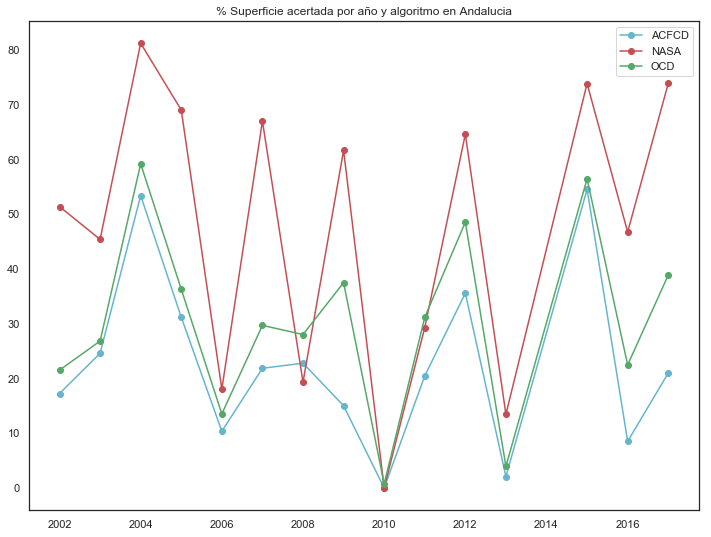

In [228]:
for j, df in enumerate(all_df):
    
    by_year = df.groupby(['YEAR']).sum()

    plt.figure(figsize=(12,9))

    plt.plot((by_year['Area_ACFCD'] /  by_year['Area_ha']) * 100, color='c', marker='o')

    plt.plot((by_year['Area_NASA'] /  by_year['Area_ha']) * 100, color='r', marker='o')

    plt.plot((by_year['Area_OCD'] /  by_year['Area_ha']) * 100, color='g', marker='o')

    plt.legend(labels=['ACFCD','NASA','OCD'])

    plt.title(label='% Superficie acertada por año y algoritmo en ' + df_str[j])

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Text(0.5, 1.0, 'Superficie clasificada según cobertura MFE 1:50.000 en total')

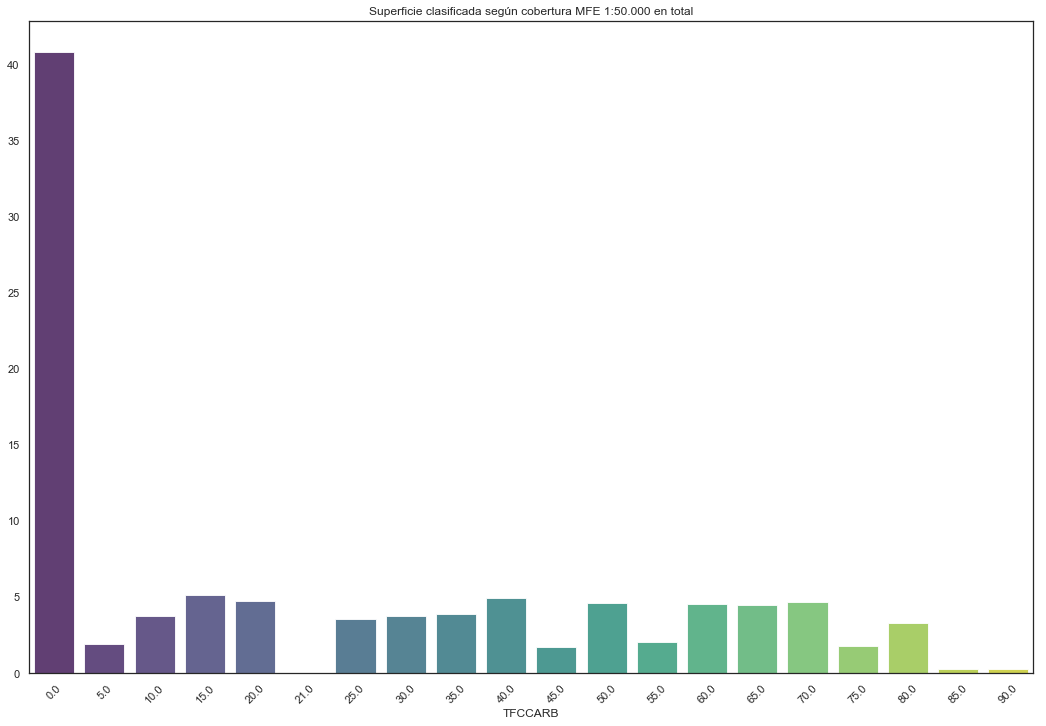

In [54]:
andalucia_tot = pd.read_csv('andalucia.csv')

catalunia_tot = pd.read_csv('catalunia.csv')

df = pd.concat([andalucia_tot,catalunia_tot])

plt.figure(figsize=(18,12))

by_definicion = df.groupby('TFCCARB')['Area_ha'].sum()
    
total_area = by_definicion.values.sum()

chart = sns.barplot(x=by_definicion.index, y=(by_definicion.values / total_area) * 100, palette='viridis', alpha=0.85)
    
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    
plt.title(label='Superficie clasificada según cobertura MFE 1:50.000 en total')

In [51]:
andalucia_tot.columns

Index(['ARBOLADO', 'Area_ACFCD', 'Area_NASA', 'Area_OCD', 'Area_ha', 'CAMPANA',
       'CCAA_MFE50', 'CLASMFE_IF', 'CLAS_IFN', 'CLA_FORARB', 'COMENTARIO',
       'CUADRICULA', 'DEFINICION', 'DISTRIB', 'ESCENA_REF', 'FCC_POND',
       'FECHA', 'FECHA_FIN', 'FECHA_INIC', 'ID', 'ID_FORARB', 'Id', 'MATORRAL',
       'MUNICIPIO', 'NOM_FORARB', 'PASTIZALES', 'PLACE', 'POLIGON',
       'PROVINCIA', 'PROV_MFE50', 'RESOLUCION', 'SENSOR_REF', 'SHAPE_AREA',
       'SUPERFICIE', 'Supac_ACFCD', 'Supac_NASA', 'Supac_OCD', 'TFCCARB',
       'TFCCTOT', 'TIPESTR', 'TIPO_BOSQU', 'USOS_GENER', 'USOS_SUELO', 'Year',
       'dis_str', 'geometry', 'id', 'id_incmfe', 'id_incmfe_index',
       'id_index'],
      dtype='object')